We have three files extracted
exp_coords_NPs.txt
sim_coords_NPs.txt
sim_sig_vonMises_NPs.txt

num nodes in bothsim files are equal. Num nodes in exp coords is not the same as in sim but its cad model is roughly same as sim.

this is because sim has load BC (sheet metal forming), not disp BC, and thus deformed result is not same as intended CAD

This is the point cloud interpolation

### Step 1: Load the matrices from the .txt file

In [1]:
import numpy as np

def load_exp_nodes(path):
    ids = []
    coords = []
    with open(path, "r") as f:
        for line in f:
            if not line.strip():
                continue
            if line.startswith("*") or line.startswith("$"):
                continue

            # Make sure line is long enough
            line = line.rstrip("\n")
            if len(line) < 56:
                continue

            nid = int(line[0:8])
            x = float(line[8:24])
            y = float(line[24:40])
            z = float(line[40:56])

            ids.append(nid)
            coords.append([x, y, z])

    return np.array(ids, dtype=int), np.array(coords, dtype=float)

def load_sim_nodes(path):
    ids = []
    coords = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("*") or line.startswith("$"):
                continue

            parts = line.split()
            if len(parts) < 4:
                continue

            nid = int(parts[0])
            x = float(parts[1])
            y = float(parts[2])
            z = float(parts[3])

            ids.append(nid)
            coords.append([x, y, z])

    return np.array(ids, dtype=int), np.array(coords, dtype=float)

def load_SDV(path):
    ids = []
    vals = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("*") or line.startswith("$"):
                continue

            parts = line.split()
            if len(parts) < 2:
                continue

            nid = int(parts[0])
            v = float(parts[1])

            ids.append(nid)
            vals.append(v)

    return np.array(ids, dtype=int), np.array(vals, dtype=float)


# 4) SIM shell element connectivity  (*ELEMENT_SHELL with padded zeros)
def load_sim_shell_elements(path):
    """
    Read LS-DYNA *ELEMENT_SHELL file like:

    *ELEMENT_SHELL
    $    eid     pid      n1      n2      n3      n4      n5      n6      n7      n8
           1       1       1       4       5       2       0       0       0       0
           2       1       2       5       6       3       0       0       0       0
           ...

    Returns:
        eids : (Ne,) int array
        pids : (Ne,) int array
        conn : (Ne, nnode) int array  (zeros removed, so usually nnode=4)
    """
    eids = []
    pids = []
    conn = []

    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("*") or line.startswith("$"):
                continue

            parts = line.split()
            if len(parts) < 6:
                # need at least eid, pid, n1..n4
                continue

            eid = int(parts[0])
            pid = int(parts[1])

            # remaining entries are node IDs (may include zeros for unused corners)
            node_ids = [int(p) for p in parts[2:] if int(p) != 0]

            eids.append(eid)
            pids.append(pid)
            conn.append(node_ids)

    eids = np.array(eids, dtype=int)
    pids = np.array(pids, dtype=int)
    conn = np.array(conn, dtype=int)  # assumes all elements have same # of nodes
    return eids, pids, conn


# 5) EXP shell element connectivity  (*ELEMENT_SHELL without zeros)
def load_exp_shell_elements(path):
    """
    Read experimental *ELEMENT_SHELL file like:

    *ELEMENT_SHELL
       40741       2   43971   43972   43902   43901
       40742       2   43972   43973   43903   43902
       ...

    Returns:
        eids : (Ne,) int array
        pids : (Ne,) int array
        conn : (Ne, 4) int array
    """
    eids = []
    pids = []
    conn = []

    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("*") or line.startswith("$"):
                continue

            parts = line.split()
            if len(parts) < 6:
                # eid, pid, n1..n4
                continue

            eid = int(parts[0])
            pid = int(parts[1])
            node_ids = [int(p) for p in parts[2:6]]

            eids.append(eid)
            pids.append(pid)
            conn.append(node_ids)

    eids = np.array(eids, dtype=int)
    pids = np.array(pids, dtype=int)
    conn = np.array(conn, dtype=int)
    return eids, pids, conn



print()
exp_ids, exp_coords = load_exp_nodes("exp_coords_NPs.txt")
print("Shape of exp_ids:", exp_ids.shape)
print("Shape of exp_coords:", exp_coords.shape)
print(exp_ids[:5])
print(exp_coords[:5])

print()
sim_ids, sim_coords = load_sim_nodes("sim_coords_NPs.txt")
print("Shape of sim_ids:", sim_ids.shape)
print("Shape of sim_coords:", sim_coords.shape)
print(sim_ids[:5])
print(sim_coords[:5])

print()
sig_ids, sim_sig_vals = load_SDV("sim_sig_vonMises_NPs.txt")
print("Shape of sig_ids:", sig_ids.shape)
print("Shape of sim_sig_vals:", sim_sig_vals.shape)
print(sig_ids[:5])
print(sim_sig_vals[:5])

print()
sim_eids, sim_pids, sim_conn = load_sim_shell_elements("sim_element_connectivity.txt")
print("Shape of sim_eids:", sim_eids.shape)
print("Shape of sim_pids:", sim_pids.shape)
print("Shape of sim_conn:", sim_conn.shape)
print(sim_eids[:5])
print(sim_pids[:5])
print(sim_conn[:5])

print()
exp_eids, exp_pids, exp_conn = load_exp_shell_elements("exp_element_connectivity.txt")
print("Shape of exp_eids:", exp_eids.shape)
print("Shape of exp_pids:", exp_pids.shape)
print("Shape of exp_conn:", exp_conn.shape)
print(exp_eids[:5])
print(exp_pids[:5])
print(exp_conn[:5])

sim_total_nodes = sim_coords.shape[0]
exp_total_nodes = exp_coords.shape[0]
sim_total_elems = sim_conn.shape[0]
exp_total_elems = exp_conn.shape[0]

print()
print("sim_total_nodes =", sim_total_nodes)
print("exp_total_nodes =", exp_total_nodes)
print("sim_total_elems =", sim_total_elems)
print("exp_total_elems =", exp_total_elems)



Shape of exp_ids: (8236,)
Shape of exp_coords: (8236, 3)
[1 2 3 4 5]
[[ 70.66840319 -68.00003755 -22.79932967]
 [ 69.24672329 -68.00003753 -23.78386867]
 [ 67.67323302 -68.00003752 -24.50123927]
 [ 70.66839424 -66.00003709 -22.79933808]
 [ 69.24671713 -66.00003699 -23.78387217]]

Shape of sim_ids: (8120,)
Shape of sim_coords: (8120, 3)
[43901 43902 43903 43904 43905]
[[-115.       -69.5122     0.     ]
 [-115.       -67.49735    0.     ]
 [-115.       -65.48251    0.     ]
 [-115.       -63.46766    0.     ]
 [-115.       -61.45281    0.     ]]

Shape of sig_ids: (8120,)
Shape of sim_sig_vals: (8120,)
[43901 43902 43903 43904 43905]
[0. 0. 0. 0. 0.]

Shape of sim_eids: (7935,)
Shape of sim_pids: (7935,)
Shape of sim_conn: (7935, 4)
[40741 40742 40743 40744 40745]
[2 2 2 2 2]
[[43971 43972 43902 43901]
 [43972 43973 43903 43902]
 [43973 43974 43904 43903]
 [43974 43975 43905 43904]
 [43975 43976 43906 43905]]

Shape of exp_eids: (7560,)
Shape of exp_pids: (7560,)
Shape of exp_conn: (75

### Step 2: Plot the contour of the simulation

In [2]:
!pip install pyvista

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\nguyen\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### General function to plot the mesh

In [3]:
import numpy as np
import pyvista as pv

def plot_shell_field(coords,
                     conn,
                     ids,
                     vals,
                     ):

    # ---- assumed available from your loaders ----
    # ids:    (Ns,) int
    # coords: (Ns, 3)
    # vals:   (Ns,) float
    # conn:   (Ne, 4) int   # element connectivity in terms of node IDs

    # 1) Map node IDs -> index
    id_to_idx = {nid: i for i, nid in enumerate(ids)}

    # 2) Build nodal σ_vM aligned with coords
    nodal_mises = np.full(coords.shape[0], np.nan, dtype=float)
    for nid, val in zip(ids, vals):
        idx = id_to_idx.get(nid, None)
        if idx is not None:
            nodal_mises[idx] = val

    if np.any(np.isnan(nodal_mises)):
        print("Warning: some sim nodes have no σ_vM value")

    # 3) Connectivity: node IDs -> 0-based indices
    conn = np.asarray(conn, dtype=int)
    nelems, nen = conn.shape  # nen should be 4

    conn_idx = np.zeros_like(conn, dtype=int)
    for e, nodes in enumerate(conn):
        conn_idx[e, :] = [id_to_idx[nid] for nid in nodes]

    # 4) VTK cells array for quads: [4, n1, n2, n3, n4, 4, n1, ...]
    cells = np.hstack(
        (
            np.full((nelems, 1), nen, dtype=np.int64),  # leading '4' per element
            conn_idx.astype(np.int64),
        )
    ).ravel()

    # Cell types: all QUAD
    celltypes = np.full(nelems, pv.CellType.QUAD, dtype=np.uint8)

    # 5) Build grid and attach σ_vM
    grid = pv.UnstructuredGrid(cells, celltypes, coords)
    grid["mises"] = nodal_mises

    xmin, xmax, ymin, ymax, zmin, zmax = grid.bounds
    # print(xmin, xmax)

    p = pv.Plotter()
    p.add_axes()
    p.show_bounds(grid='front', location='outer', all_edges=True)

    # p.enable_parallel_projection()
    p.add_mesh(
        grid,
        scalars="mises",
        cmap="jet",
        point_size=5,
        render_points_as_spheres=False,
        interpolate_before_map=True,
        show_scalar_bar=False,   # 🔹 turn off automatic bar
    )

    axes = p.show_bounds(
        grid='front',
        location='outer',
        all_edges=True,
        bounds=(xmin, xmax, ymin, ymax, zmin, zmax),
        axes_ranges=(xmin, xmax, ymin, ymax, zmin, zmax),
        n_xlabels=5,
        n_ylabels=5,
        n_zlabels=3,
        font_size=12,
        # optional:
        # n_xlabels=5,
        # n_ylabels=5,
    )

    axes.label_offset = 30.0

    p.add_scalar_bar(
        title="von Mises [MPa]",
        n_labels=5,
        vertical=True,
        position_x=0.88,
        position_y=0.1,
    )

    p.show()    

C:\Users\nguyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


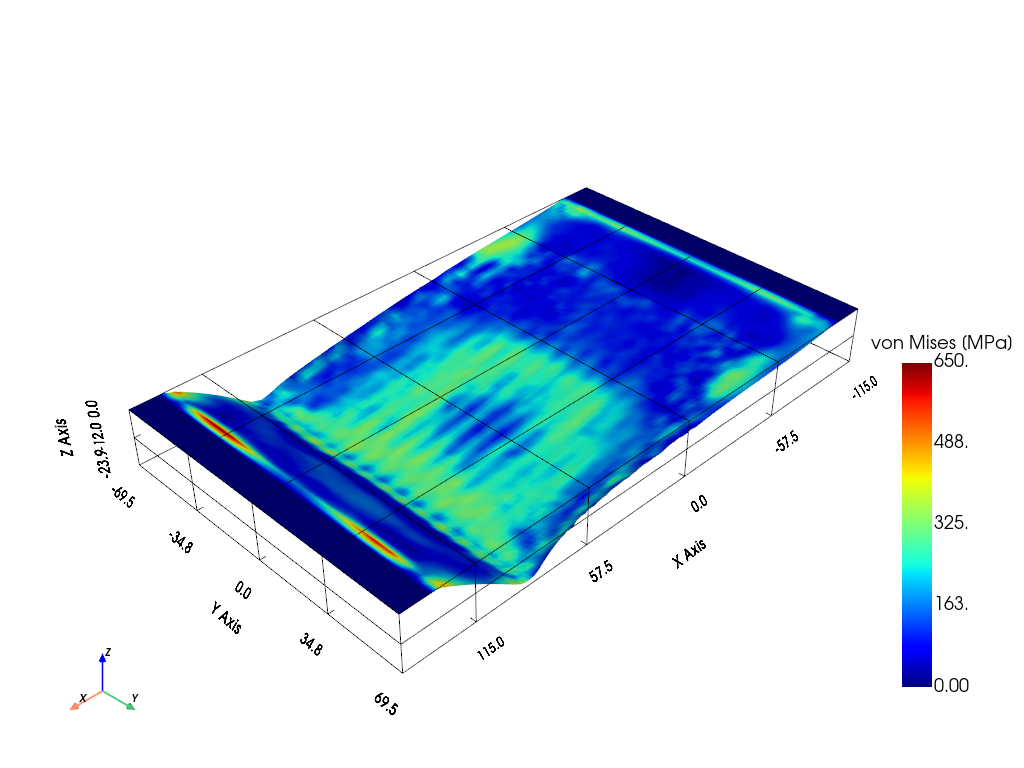

In [4]:
plot_shell_field(sim_coords, sim_conn, sim_ids, sim_sig_vals)

### Step 3: Computed sim SDV interpolated at exp nodal points

first task: we need to have the transformed sim coords as follows: 

1) they can be translated along 3 dim 
2) they can be scaled along 3 dim 
3) they can be rotated along 3 axis in total 9 unknowns. 

We need to find these 9 unknown such that the eucleadean norms between sim and exp coords are minimized. The number of NPs are different so finding closest NP of exp to sim is needed. If the geometry is symmatric like a rectangle or circle then this minimization does not have unique solution, so not only the eucleudean distance needs to be minimized but also the magnitude of the 9 unknowns as well.

However, scaling optimization would make the algorithm to cheat by squeezing the the sim mesh to be close to one single exp nodal point, so we would scaled it analytically using (max -min) of each dim between sim and exp

In [5]:
import numpy as np
from scipy.spatial import cKDTree
from scipy.optimize import minimize

# -------------------------------
# 1) Compute axis-wise scale
# -------------------------------
def compute_axis_scales(sim_coords, exp_coords):
    sim_min = sim_coords.min(axis=0)
    sim_max = sim_coords.max(axis=0)
    exp_min = exp_coords.min(axis=0)
    exp_max = exp_coords.max(axis=0)

    sim_range = sim_max - sim_min
    exp_range = exp_max - exp_min

    s = np.ones(3, dtype=float)
    for i in range(3):
        if sim_range[i] > 0:
            s[i] = exp_range[i] / sim_range[i]
        else:
            s[i] = 1.0   # avoid division by zero for perfectly flat axis

    return s  # [sx, sy, sz]

# -------------------------------
# 2) Rotation from Euler angles
# -------------------------------
def euler_to_R(rx, ry, rz):
    """
    Rotation matrix R = Rz * Ry * Rx
    Angles in radians.
    """
    cx, cy, cz = np.cos([rx, ry, rz])
    sx, sy, sz = np.sin([rx, ry, rz])

    Rx = np.array([[1, 0, 0],
                   [0, cx, -sx],
                   [0, sx,  cx]])

    Ry = np.array([[ cy, 0, sy],
                   [  0, 1,  0],
                   [-sy, 0, cy]])

    Rz = np.array([[cz, -sz, 0],
                   [sz,  cz, 0],
                   [ 0,   0, 1]])

    return Rz @ Ry @ Rx  # intrinsic rotations

# -------------------------------
# 3) Transform application (rigid only)
# -------------------------------
def apply_transform_rigid(coords_scaled, params):
    """
    coords_scaled: pre-scaled sim_coords (Ns, 3)
    params = [tx, ty, tz, rx, ry, rz]
    """
    t = np.array(params[0:3])          # translation
    rx, ry, rz = params[3:6]           # angles

    R = euler_to_R(rx, ry, rz)         # (3,3)
    X = coords_scaled @ R.T + t        # rotate + translate
    return X

# -------------------------------
# 4) Objective function (6 unknowns)
# -------------------------------
def registration_objective_rigid(params, sim_coords_scaled, exp_coords,
                                 lam_t=1e-4, lam_r=1e-4,
                                 sample_step=1):
    """
    params: [tx, ty, tz, rx, ry, rz]
    sim_coords_scaled: sim coords already scaled per axis
    sample_step: use every kth sim node for speed (1 = all).
    """

    # subset for speed if wanted
    X = sim_coords_scaled[::sample_step]

    # transform sim points
    X_trans = apply_transform_rigid(X, params)

    # nearest neighbor distances to experimental cloud
    tree = cKDTree(exp_coords)
    dists, _ = tree.query(X_trans, k=1)
    data_term = np.mean(dists**2)

    # regularization terms
    t = np.array(params[0:3])
    r = np.array(params[3:6])

    reg_t = lam_t * np.dot(t, t)    # keep translation small-ish
    reg_r = lam_r * np.dot(r, r)    # keep angles small-ish

    return data_term + reg_t + reg_r

# -------------------------------
# 5) Main alignment function
# -------------------------------
def align_sim_to_exp_with_bbox_scale(sim_coords, exp_coords,
                                     maxiter=80, sample_step=1):
    """
    1) Compute per-axis scales from bounding boxes.
    2) Pre-scale sim_coords.
    3) Optimize rigid motion (tx,ty,tz,rx,ry,rz) on scaled coords.
    Returns:
        s      : (3,) scale factors [sx, sy, sz]
        params : (6,) [tx, ty, tz, rx, ry, rz]
        sim_aligned : (Ns, 3), transformed coordinates in exp space
    """

    # 1) Compute scaling
    s = compute_axis_scales(sim_coords, exp_coords)  # [sx, sy, sz]
    print("Axis scales [sx, sy, sz] =", s)

    # 2) Pre-scale sim coords
    sim_coords_scaled = sim_coords * s  # broadcast along rows

    # 3) Initial guess for rigid motion: centroid alignment, no rotation
    c_sim = sim_coords_scaled.mean(axis=0)
    c_exp = exp_coords.mean(axis=0)
    t0 = c_exp - c_sim
    r0 = np.zeros(3)

    p0 = np.concatenate([t0, r0])  # [tx, ty, tz, rx, ry, rz]

    res = minimize(
        registration_objective_rigid,
        p0,
        args=(sim_coords_scaled, exp_coords),
        method="L-BFGS-B",
        options={"maxiter": maxiter, "ftol": 1e-9}
    )

    print("Optimization success:", res.success)
    print("Final cost:", res.fun)
    print("Optimal params (tx,ty,tz,rx,ry,rz):")
    print(res.x)

    # 4) Apply transform to all *scaled* sim coords
    sim_aligned = apply_transform_rigid(sim_coords_scaled, res.x)

    return s, res.x, sim_aligned

s_vec, params_opt, sim_coords_transformed = align_sim_to_exp_with_bbox_scale(
    sim_coords,
    exp_coords,
    maxiter=50,
    sample_step=1,   # or 1 for all nodes
)

Axis scales [sx, sy, sz] = [0.867215   1.0070178  1.19518891]
Optimization success: False
Final cost: 17.490669553057305
Optimal params (tx,ty,tz,rx,ry,rz):
[-3.56683728e+00 -3.74238327e-01 -5.15637370e+00  4.44709343e-03
  9.69391314e-03 -1.75243856e-02]


### Purely analytic strategy: only scaling and translating to match the max and min of exp

In [6]:
import numpy as np

def analytic_align_sim_to_exp(sim_coords, exp_coords):
    """
    Analytic alignment:
    1) Per-axis scaling from bbox ranges (sim -> exp)
    2) Per-axis translation so max(sim_scaled) = max(exp)

    sim_coords : (Ns, 3)
    exp_coords : (Ne, 3)

    Returns
    -------
    sim_coords_transformed : (Ns, 3)
        Scaled + translated sim coordinates.
    scale : (3,)
        Per-axis scales [sx, sy, sz].
    translation : (3,)
        Per-axis translations [tx, ty, tz] applied *after* scaling.
    """

    sim_coords = np.asarray(sim_coords, dtype=float)
    exp_coords = np.asarray(exp_coords, dtype=float)

    # --- 1) Compute per-axis scales from bounding box ranges ---
    sim_min = sim_coords.min(axis=0)
    sim_max = sim_coords.max(axis=0)
    exp_min = exp_coords.min(axis=0)
    exp_max = exp_coords.max(axis=0)

    sim_range = sim_max - sim_min
    exp_range = exp_max - exp_min

    scale = np.ones(3, dtype=float)
    for i in range(3):
        if sim_range[i] > 0.0:
            scale[i] = exp_range[i] / sim_range[i]
        else:
            scale[i] = 1.0  # avoid division by zero if perfectly flat

    # scale sim coords
    sim_scaled = sim_coords * scale  # broadcast along rows

    # --- 2) Compute translation so that max(sim_scaled) = max(exp) per axis ---
    sim_scaled_max = sim_scaled.max(axis=0)
    translation = exp_max - sim_scaled_max

    # apply translation
    sim_coords_transformed = sim_scaled + translation

    return sim_coords_transformed, scale, translation

sim_coords_transformed, s_vec, t_vec = analytic_align_sim_to_exp(sim_coords, exp_coords)

print("scale [sx, sy, sz]     =", s_vec)
print("translation [tx,ty,tz] =", t_vec)

import numpy as np

# Sim (transformed) bounds
sim_min = sim_coords_transformed.min(axis=0)
sim_max = sim_coords_transformed.max(axis=0)

# Exp bounds
exp_min = exp_coords.min(axis=0)
exp_max = exp_coords.max(axis=0)

print()
print("Transformed SIM bounds:")
print(f"  x: min = {sim_min[0]: .6f}, max = {sim_max[0]: .6f}")
print(f"  y: min = {sim_min[1]: .6f}, max = {sim_max[1]: .6f}")
print(f"  z: min = {sim_min[2]: .6f}, max = {sim_max[2]: .6f}")

print("\nEXP bounds:")
print(f"  x: min = {exp_min[0]: .6f}, max = {exp_max[0]: .6f}")
print(f"  y: min = {exp_min[1]: .6f}, max = {exp_max[1]: .6f}")
print(f"  z: min = {exp_min[2]: .6f}, max = {exp_max[2]: .6f}")

# Optional: show the differences in bounds
print("\nDifferences (SIM_transformed - EXP):")
print(f"  x: Δmin = {sim_min[0] - exp_min[0]: .6f}, Δmax = {sim_max[0] - exp_max[0]: .6f}")
print(f"  y: Δmin = {sim_min[1] - exp_min[1]: .6f}, Δmax = {sim_max[1] - exp_max[1]: .6f}")
print(f"  z: Δmin = {sim_min[2] - exp_min[2]: .6f}, Δmax = {sim_max[2] - exp_max[2]: .6f}")




scale [sx, sy, sz]     = [0.867215   1.0070178  1.19518891]
translation [tx,ty,tz] = [-1.14450000e-05 -1.52600000e-05 -3.11556717e-02]

Transformed SIM bounds:
  x: min = -99.729736, max =  99.729713
  y: min = -70.000038, max =  70.000008
  z: min = -28.640774, max =  0.000000

EXP bounds:
  x: min = -99.729736, max =  99.729713
  y: min = -70.000038, max =  70.000008
  z: min = -28.640774, max =  0.000000

Differences (SIM_transformed - EXP):
  x: Δmin =  0.000000, Δmax =  0.000000
  y: Δmin =  0.000000, Δmax =  0.000000
  z: Δmin =  0.000000, Δmax =  0.000000


### Plot the sim mesh at the new transformed coords

C:\Users\nguyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


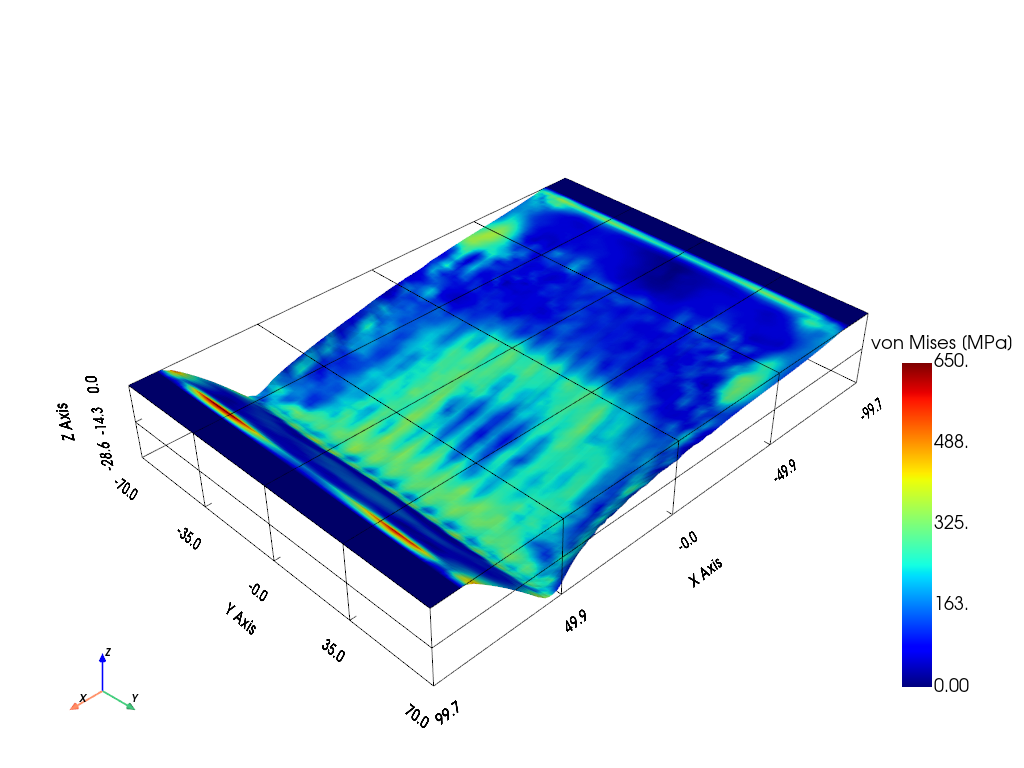

In [7]:
plot_shell_field(sim_coords_transformed, sim_conn, sim_ids, sim_sig_vals)

projected plane if XY then we discard Z dim YZ discard X dim XZ discard Y dim (this is useful for later code where the model shows most variation along a specific plane) 

then the algorithm in 2D works like this for each node of exp in 2d, find the element of sim in 2d that contains that node. if lies on edge or corner of sims then choose any random element (this is becaus shape function will make them behave correctly no matter what elements it belongs to. 

then use bilinear shape funcion to compute that node of exp from sim 4 nodal points. hardest code is only to find element ID of sim that the exp node lies in. in worst case if doesnt lie in any elements then find closest NP of sim and give it value of that closest sim

In [8]:
import numpy as np
from scipy.spatial import cKDTree

# ------------------------------------------------------------
# Helper: build 0-based connectivity from LS-DYNA node IDs
# ------------------------------------------------------------
def _build_conn_idx(sim_conn, sim_ids):
    """
    Convert LS-DYNA node IDs in sim_conn to 0-based indices
    into sim_coords / sim_sig_vals.
    """
    sim_conn = np.asarray(sim_conn, dtype=int)
    id_to_idx = {nid: i for i, nid in enumerate(sim_ids)}
    nelems, nen = sim_conn.shape
    conn_idx = np.zeros_like(sim_conn, dtype=int)
    for e in range(nelems):
        conn_idx[e, :] = [id_to_idx[nid] for nid in sim_conn[e, :]]
    return conn_idx


# ------------------------------------------------------------
# Helper: Newton solve for (ξ,η) in a bilinear quad
# ------------------------------------------------------------
def _local_coords_bilinear(xy_nodes, p, tol=1e-8, max_iter=15):
    """
    Solve for parent coords (ξ,η) such that
        x(ξ,η) = sum N_i(ξ,η) x_i = p[0]
        y(ξ,η) = sum N_i(ξ,η) y_i = p[1]
    using Newton iteration.

    xy_nodes: (4,2) array of (x_i, y_i) nodal coords
    p       : (2,) target point (x, y)
    Returns:
        xi, eta, success (bool), inside (bool)
    """
    x_i = xy_nodes[:, 0]
    y_i = xy_nodes[:, 1]
    x_target, y_target = p

    xi = 0.0
    eta = 0.0

    for _ in range(max_iter):
        # Shape functions
        N1 = 0.25 * (1 - xi) * (1 - eta)
        N2 = 0.25 * (1 + xi) * (1 - eta)
        N3 = 0.25 * (1 + xi) * (1 + eta)
        N4 = 0.25 * (1 - xi) * (1 + eta)
        N = np.array([N1, N2, N3, N4])

        # Derivatives w.r.t. xi, eta
        dN_dxi = 0.25 * np.array([
            -(1 - eta),   # dN1/dxi
             (1 - eta),   # dN2/dxi
             (1 + eta),   # dN3/dxi
            -(1 + eta),   # dN4/dxi
        ])
        dN_deta = 0.25 * np.array([
            -(1 - xi),    # dN1/deta
            -(1 + xi),    # dN2/deta
             (1 + xi),    # dN3/deta
             (1 - xi),    # dN4/deta
        ])

        # Current mapped point
        x_cur = np.dot(N, x_i)
        y_cur = np.dot(N, y_i)

        # Residual
        rx = x_cur - x_target
        ry = y_cur - y_target
        r = np.array([rx, ry])

        if np.linalg.norm(r) < tol:
            # converged; check inside in a separate step
            inside = (abs(xi) <= 1.0 + 1e-6) and (abs(eta) <= 1.0 + 1e-6)
            return xi, eta, True, inside

        # Jacobian J = [dx/dxi  dx/deta; dy/dxi  dy/deta]
        dx_dxi = np.dot(dN_dxi, x_i)
        dx_deta = np.dot(dN_deta, x_i)
        dy_dxi = np.dot(dN_dxi, y_i)
        dy_deta = np.dot(dN_deta, y_i)

        J = np.array([[dx_dxi, dx_deta],
                      [dy_dxi, dy_deta]])

        detJ = np.linalg.det(J)
        if abs(detJ) < 1e-14:
            # element is degenerate or extremely distorted here
            return xi, eta, False, False

        # Newton update
        delta = np.linalg.solve(J, -r)
        xi  += delta[0]
        eta += delta[1]

    # Not converged
    inside = (abs(xi) <= 1.0 + 1e-6) and (abs(eta) <= 1.0 + 1e-6)
    return xi, eta, False, inside


# ------------------------------------------------------------
# Main interpolation function (as you specified)
# ------------------------------------------------------------
def interpolate_sdv_2d_plane(
    sim_coords_transformed,
    exp_coords,
    sim_sig_vals,
    projected_plane="XY",
    k_elem_candidates=16
):
    """
    Interpolate SDV (e.g. von Mises) from SIM shell mesh to EXP nodes
    using 2D bilinear shape functions in a chosen projection plane.

    Parameters
    ----------
    sim_coords_transformed : (Ns,3)
        Transformed SIM nodal coordinates (after scaling/translation/etc.).
    exp_coords : (Ne,3)
        EXP nodal coordinates.
    sim_sig_vals : (Ns,)
        Scalar values at SIM nodes (aligned with sim_ids & sim_coords_transformed).
    projected_plane : {"XY", "YZ", "XZ"}
        Plane to project onto:
        - "XY": use (x, y), discard z
        - "YZ": use (y, z), discard x
        - "XZ": use (x, z), discard y
    k_elem_candidates : int
        How many nearest elements (by centroid) to try for each EXP node.

    Returns
    -------
    exp_sig_vals : (Ne,)
        Interpolated scalar at EXP nodes.
    """

    # --- choose projection indices ---
    plane = projected_plane.upper()
    if plane == "XY":
        ia, ib = 0, 1
    elif plane == "YZ":
        ia, ib = 1, 2
    elif plane == "XZ":
        ia, ib = 0, 2
    else:
        raise ValueError(f"Unsupported projected_plane: {projected_plane}")

    # --- project to 2D ---
    sim_xy = np.column_stack((sim_coords_transformed[:, ia],
                              sim_coords_transformed[:, ib]))
    exp_xy = np.column_stack((exp_coords[:, ia],
                              exp_coords[:, ib]))

    # --- build 0-based connectivity (global sim_conn & sim_ids) ---
    global sim_conn, sim_ids  # assumes they exist in your environment
    conn_idx = _build_conn_idx(sim_conn, sim_ids)  # (Ne,4)

    nelems = conn_idx.shape[0]

    # --- precompute element centroids in 2D ---
    elem_centroids = np.zeros((nelems, 2), dtype=float)
    for e in range(nelems):
        elem_xy = sim_xy[conn_idx[e, :]]
        elem_centroids[e, :] = elem_xy.mean(axis=0)

    # KDTree on element centroids for candidate search
    tree_elems = cKDTree(elem_centroids)

    # KDTree on SIM nodes for fallback nearest-node interpolation
    tree_nodes = cKDTree(sim_xy)

    exp_sig_vals = np.zeros(exp_coords.shape[0], dtype=float)

    for j, p in enumerate(exp_xy):
        # 1) find k nearest element centroids
        k = min(k_elem_candidates, nelems)
        d_e, idx_e = tree_elems.query(p, k=k)

        # ensure idx_e iterable
        if k == 1:
            idx_e = np.array([idx_e])

        found = False

        # 2) try each candidate element: solve (ξ,η), check inside, interpolate
        for e in idx_e:
            node_ids = conn_idx[e, :]   # 4 node indices (0-based)
            xy_nodes = sim_xy[node_ids] # (4,2)

            xi, eta, converged, inside = _local_coords_bilinear(xy_nodes, p)
            if not inside:
                continue  # try next candidate

            # use bilinear shape functions at (xi, eta)
            N1 = 0.25 * (1 - xi) * (1 - eta)
            N2 = 0.25 * (1 + xi) * (1 - eta)
            N3 = 0.25 * (1 + xi) * (1 + eta)
            N4 = 0.25 * (1 - xi) * (1 + eta)
            N = np.array([N1, N2, N3, N4])

            vals_elem = sim_sig_vals[node_ids]  # scalar at 4 SIM nodes
            exp_sig_vals[j] = float(N @ vals_elem)
            found = True
            break  # no need to check other elements

        if not found:
            # 3) Fallback: nearest SIM node in 2D, copy its value
            _, idx_node = tree_nodes.query(p, k=1)
            exp_sig_vals[j] = float(sim_sig_vals[idx_node])

    return exp_sig_vals

exp_sig_vals = interpolate_sdv_2d_plane(
    sim_coords_transformed,
    exp_coords,
    sim_sig_vals,
    projected_plane="XY",
)


C:\Users\nguyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


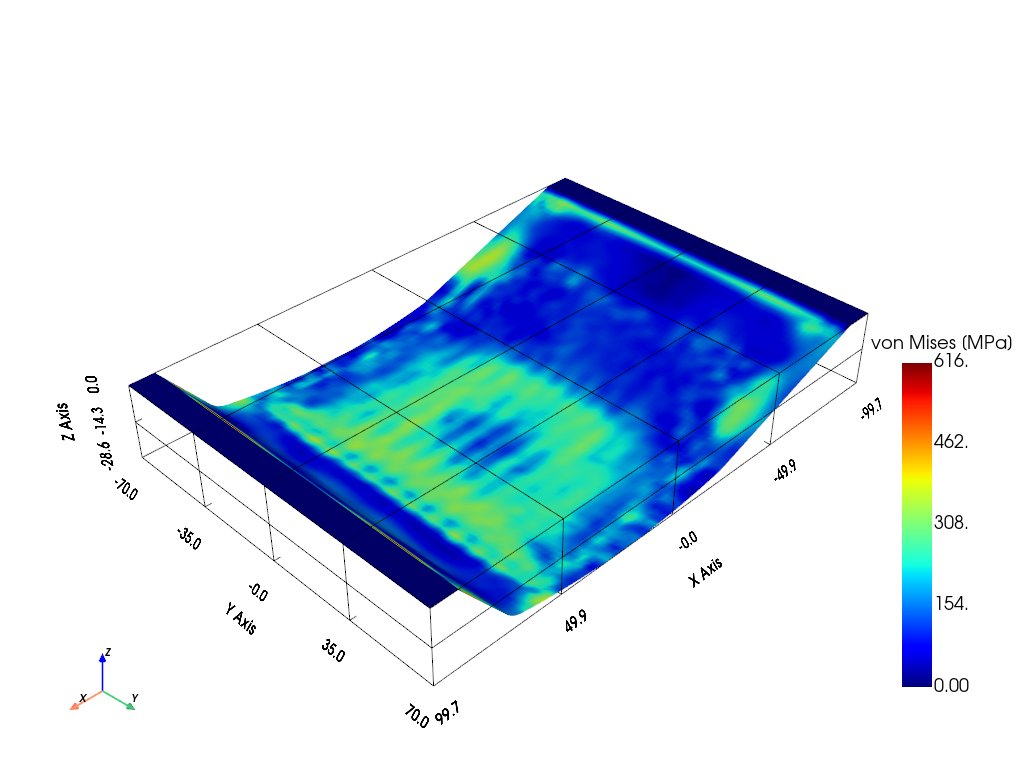

In [9]:
plot_shell_field(exp_coords, exp_conn, exp_ids, exp_sig_vals)